In [1]:
%pylab inline
import datetime as dt
import os
import numpy as np
import pylab as pl
import pandas as pd

from scipy.stats import gaussian_kde

Populating the interactive namespace from numpy and matplotlib


In [2]:
SUBTAG_df = pd.read_hdf('./output/SUBTAG_sub_20120806_171547_tag_20120806_171547.hdf5')

SUB_df_sample = pd.read_hdf('./DATA/sample_PR_GR_match_SUB.hdf5')
TAG_df_sample = pd.read_hdf('./DATA/sample_PR_GR_match_TAG.hdf5')

In [3]:
def calc_bias_std(df_sample, gr_colname, sr_colname, weights):

    refsr = np.array(df_sample[sr_colname])
    refgr = np.array(df_sample[gr_colname])

    deltaZ = refgr-refsr
    deltaZ = deltaZ[np.where(~np.isnan(deltaZ))]

    bias = np.mean(deltaZ)
    idx = np.where(~np.isnan(deltaZ))[0]
    bias_w = np.average(deltaZ[idx], weights = np.ma.masked_invalid(df_sample[weights].values[idx]))

    std = np.std(deltaZ)
    std_w = np.sqrt(np.average((deltaZ[idx]-bias)**2, weights=np.ma.masked_invalid(df_sample[weights].values[idx])))
    
    return bias,bias_w,std,std_w

In [4]:
SUBbias,SUBbias_w,SUBstd,SUBstd_w = calc_bias_std(SUB_df_sample, sr_colname='sr_ref_ss', gr_colname='gr_ref', weights='quality_BBF')
TAGbias,TAGbias_w,TAGstd,TAGstd_w = calc_bias_std(TAG_df_sample, sr_colname='sr_ref_ss', gr_colname='gr_ref_y', weights='qual_PIA')

In [5]:
print('Simple bias:{0}'.format(SUBbias))
print('Weighted bias (BBF):{0}'.format(SUBbias_w))

print('Simple std:{0}'.format(SUBstd))
print('Weighted std (BBF):{0}'.format(SUBstd_w))

Simple bias:-6.029612030298708
Weighted bias (BBF):-5.641209361988233
Simple std:5.1805213563994394
Weighted std (BBF):4.825013075033122


In [6]:
print('Simple bias:{0}'.format(TAGbias))
print('Weighted bias (BBF):{0}'.format(TAGbias_w))

print('Simple std:{0}'.format(TAGstd))
print('Weighted std (BBF):{0}'.format(TAGstd_w))

Simple bias:-14.278162272643113
Weighted bias (BBF):-13.462342521671248
Simple std:4.526864290452586
Weighted std (BBF):4.42712534124215


### Correct the individual radar reflectivities

In [7]:
SUBTAG_Z_sub = SUBTAG_df['sub_overlap']
SUBTAG_Z_tag = SUBTAG_df['tag_overlap']

Using the weighted biases:

In [8]:
SUBTAG_Z_sub_corr_w = SUBTAG_Z_sub - SUBbias_w
SUBTAG_Z_tag_corr_w = SUBTAG_Z_tag - TAGbias_w

In [9]:
bias_SUBTAG = np.mean(SUBTAG_Z_tag - SUBTAG_Z_sub)
bias_SUBTAGcorr_w = np.mean(SUBTAG_Z_tag_corr_w - SUBTAG_Z_sub_corr_w)

### Plot KDEs

In [10]:
def calculate_kde(xvals,yvals):

#     y = np.array(df_sample.tag_overlap)
#     x = np.array(df_sample.sub_overlap)
    y_ = np.array(yvals)
    x_ = np.array(xvals)

    x = x_[np.where(~np.isnan(x_) & ~np.isnan(y_))]
    y = y_[np.where(~np.isnan(x_) & ~np.isnan(y_))]

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    return x,y,z

In [11]:
srref_SUB = SUB_df_sample['sr_ref_ss'].values
grref_SUB = SUB_df_sample['gr_ref'].values
Q_SUB = SUB_df_sample['quality_BBF']

srref_TAG = TAG_df_sample['sr_ref_ss'].values
grref_TAG = TAG_df_sample['gr_ref_y'].values
Q_TAG = TAG_df_sample['qual_PIA']

In [12]:
qual_comb = SUBTAG_df['Q_SUB']*SUBTAG_df['Q_TAG']
idx = np.where(qual_comb.values>0.0)

In [13]:
x1,y1,z1 = calculate_kde(srref_SUB[Q_SUB>0.7],grref_SUB[Q_SUB>0.7])
x2,y2,z2 = calculate_kde(srref_TAG[Q_TAG>0.7],grref_TAG[Q_TAG>0.7])
x3,y3,z3 = calculate_kde(SUBTAG_Z_sub.values[idx], SUBTAG_Z_tag.values[idx])
x4,y4,z4 = calculate_kde(SUBTAG_Z_sub_corr_w.values[idx], SUBTAG_Z_tag_corr_w.values[idx])

z1/=z1.max()
z2/=z2.max()
z3/=z3.max()
z4/=z4.max()

In [14]:
norm=plt.Normalize(0,1)
cmap_midnightblue = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#bcdbe6','#579cba','#0d3253'])

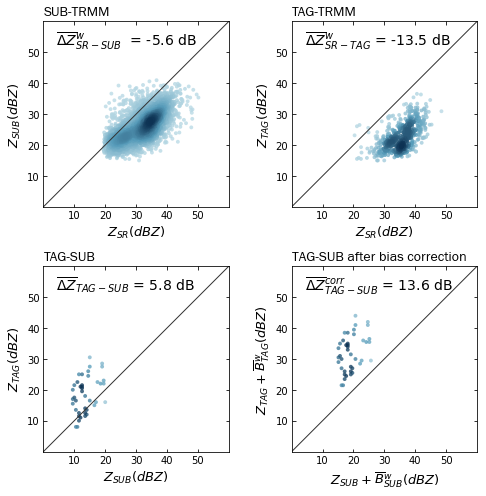

In [15]:
fig = pl.figure(figsize=(7,7))

ax1 = fig.add_subplot(2,2,1, aspect='equal')
# pm1 = ax1.scatter(sr_SUB_sorted,gr_SUB_sorted, alpha=0.8,c=qualBBF_SUB_sorted, 
#             cmap=new_cmap_Teal,edgecolor='None',vmin=0, s=15)
pm1 = ax1.scatter(x1,y1, alpha=0.8,c=z1, 
            cmap=cmap_midnightblue,edgecolor='None',vmin=0, s=15)
ax1.plot([0,60],[0,60], linestyle="solid", color="0.2", lw=1)

ax1.set_xticks(range(0,56,10))
ax1.set_xlabel('$Z_{SR} (dBZ)$', fontsize=13)
ax1.set_ylabel('$Z_{SUB} (dBZ)$', fontsize=13)

ax2 = fig.add_subplot(2,2,2, aspect='equal')
# pm2 = ax2.scatter(sr_TAG_sorted,gr_TAG_sorted, alpha=0.8,c=qualBBF_TAG_sorted, 
#             cmap=new_cmap_Teal,edgecolor='None',vmin=0, s=15)
pm2 = ax2.scatter(x2,y2, alpha=0.8,c=z2, 
            cmap=cmap_midnightblue,edgecolor='None',vmin=0, s=15)
ax2.plot([0,60],[0,60], linestyle="solid", color="0.2", lw=1)
ax2.set_xticks(range(0,56,10))
ax2.set_xlabel('$Z_{SR} (dBZ)$', fontsize=13)
ax2.set_ylabel('$Z_{TAG} (dBZ)$', fontsize=13)

ax3 = fig.add_subplot(2,2,3, aspect='equal')
pm3 = ax3.scatter(x3,y3, alpha=0.8,c=z3, 
            cmap=cmap_midnightblue,edgecolor='None',vmin=0, s=15)
ax3.plot([0,60],[0,60], linestyle="solid", color="0.2", lw=1)
ax3.set_xlabel('$Z_{SUB} (dBZ)$', fontsize=13)
ax3.set_ylabel('$Z_{TAG} (dBZ)$', fontsize=13)


ax4 = fig.add_subplot(2,2,4, aspect='equal')
# pl.scatter(SUBTAG_Z_sub_corr,SUBTAG_Z_tag_corr,vmin=0, s=15)
pm4 = ax4.scatter(x4,y4, alpha=0.8,c=z4, 
            cmap=cmap_midnightblue,edgecolor='None',vmin=0, s=15)
ax4.plot([0,60],[0,60], linestyle="solid", color="0.2", lw=1)
ax4.set_xlabel('$Z_{SUB} + \overline{{B}}^w_{{SUB}} (dBZ)$', fontsize=13)
ax4.set_ylabel('$Z_{TAG} + \overline{{B}}^w_{{TAG}} (dBZ)$', fontsize=13)

ax1.set_title('SUB-TRMM', loc='left', fontsize=14, fontname='Franklin Gothic Book')
ax2.set_title('TAG-TRMM', loc='left', fontsize=14, fontname='Franklin Gothic Book')
ax3.set_title('TAG-SUB', loc='left', fontsize=14, fontname='Franklin Gothic Book')
ax4.set_title('TAG-SUB after bias correction', loc='left', fontsize=14, fontname='Franklin Gothic Book')

#pl.suptitle('SR-GR-based bias correction improves GR-GR consistency', x=0.105, y=1.03, ha='left', fontname='Franklin Gothic Medium', fontsize=17)

for ax in [ax1,ax2,ax3,ax4]:
    ax.tick_params(direction='in', top=True, right=True)
    ax.set_xlim(0,60)
    ax.set_ylim(0,60)
    ax.set_xticks(range(10,56,10))
    ax.set_yticks(range(10,56,10))


text1 = "$ \overline{{\Delta Z}}^w_{{SR-SUB}}$  = {:0.1f} dB".format(SUBbias_w)
text2 = "$ \overline{{\Delta Z}}^w_{{SR-TAG}}$ = {:0.1f} dB".format(TAGbias_w)
text3 = "$ \overline{{\Delta Z}}_{{TAG-SUB}}$ = {:0.1f} dB".format(bias_SUBTAG)
text4 = "$ \overline{{\Delta Z}}^{{corr}}_{{TAG-SUB}}$ = {:0.1f} dB".format(bias_SUBTAGcorr_w)

ax1.annotate(text1, fontsize=14,#fontname='Franklin Gothic Book',
            xy=(0.07, 0.87), xycoords='axes fraction')
ax2.annotate(text2, fontsize=14,#fontname='Franklin Gothic Book',
            xy=(0.07, 0.87), xycoords='axes fraction')
ax3.annotate(text3, fontsize=14,#fontname='Franklin Gothic Book',
            xy=(0.07, 0.87), xycoords='axes fraction')
ax4.annotate(text4, fontsize=14,#fontname='Franklin Gothic Book',
            xy=(0.07, 0.87), xycoords='axes fraction')

pl.tight_layout()
